# Seleção do Modelo, *Underfitting*, e *Overfitting*

Explorar esses conceitos interativamente
ajustando polinômios aos dados

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

Usar o seguinte polinômio cúbico para gerar os rótulos
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

Dê uma olhada nas 2 primeiras amostras

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.0677],
         [1.1793]]),
 tensor([[1.0000e+00, 6.7731e-02, 2.2938e-03, 5.1786e-05, 8.7688e-07, 1.1878e-08,
          1.3409e-10, 1.2974e-12, 1.0985e-14, 8.2667e-17, 5.5991e-19, 3.4476e-21,
          1.9459e-23, 1.0138e-25, 4.9049e-28, 2.2148e-30, 9.3755e-33, 3.7354e-35,
          1.4056e-37, 5.0106e-40],
         [1.0000e+00, 1.1793e+00, 6.9534e-01, 2.7333e-01, 8.0582e-02, 1.9006e-02,
          3.7355e-03, 6.2930e-04, 9.2765e-05, 1.2155e-05, 1.4334e-06, 1.5367e-07,
          1.5101e-08, 1.3699e-09, 1.1539e-10, 9.0718e-12, 6.6863e-13, 4.6382e-14,
          3.0387e-15, 1.8860e-16]]),
 tensor([4.9295, 5.6772]))

Implementar uma função para avaliar a perda em um determinado conjunto de dados

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

Definimos a função de treinamento

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

Ajuste de Função Polinomial de Terceira Ordem (Normal)

weight: [[ 4.9845066  1.198048  -3.3657222  5.6218867]]


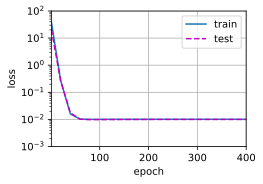

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

Ajuste de Função Linear (*Underfitting*)

weight: [[2.8097544 5.8229284]]


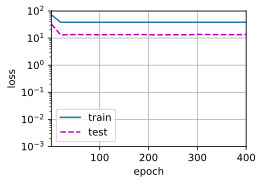

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

Ajuste de Função Polinomial de Ordem Superior (Overfitting)

weight: [[ 4.982931    1.2265587  -3.3544781   5.4541326  -0.09373245  0.5836463
   0.64222693 -0.24504533 -0.05877461  0.02516887  0.05020873 -0.13465318
  -0.02540386  0.04453609  0.02328553  0.20334226 -0.15728581 -0.0057102
   0.07939518  0.1293253 ]]


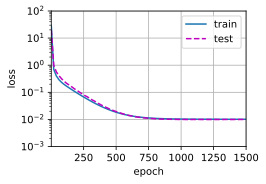

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)